# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: {YOUR NAMES}  
Summer Term 2024  

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Perceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [2]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [192]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchsummary
from sklearn.model_selection import train_test_split
import torch.nn.functional as F


torch.manual_seed(42) # Set manual seed

In [193]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [183]:
batch_size = 1024

mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [111]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
                                
# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.  

Files already downloaded and verified
Files already downloaded and verified


In [112]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)


In [113]:
## TODO: plot images with their labels after augmentations

def imshow(img):
    """
    Function to show an image after denormalizing.
    """
    img = img.numpy().transpose((1, 2, 0))  # rearrange dimensions to height x width x channels from channels x height x weidth
    
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    
    #normalize = (channel_value - mean)/std
    img = std * img + mean  # denormalize

    plt.imshow(img)
    
    
def show_batch(dl):
    """
    Display images with labels in a batch.
    """
    images, labels = next(iter(dl))

    
    # Plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in range(20):  
        ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
        imshow(images[idx])
        ax.set_title(labels[idx].item())


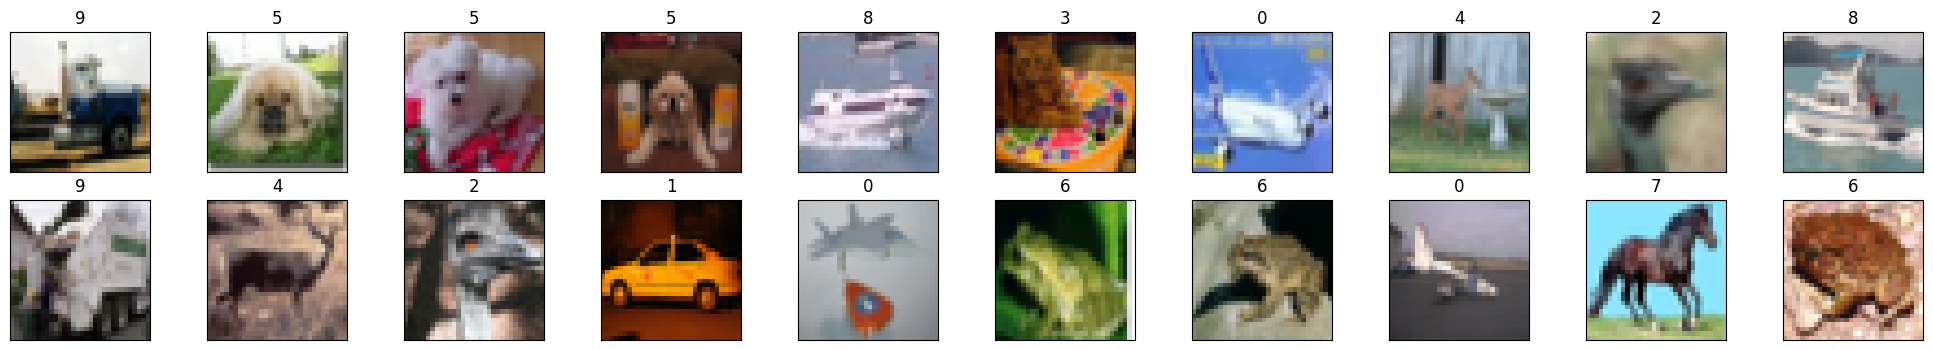

In [114]:
show_batch(train_loader)

In [115]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [174]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    if total == 0:
        return 0
    
    return correct/total

In [175]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 


def train(dataloader, optimizer, model, loss_fn, device):
    """ method to train the model """

    # TODO: refine the training function from above
  # it should contain:
  # - saving of losses
  # - calculation of accuracy
  # - returning the mean loss and accuracy
    
    train_loss = 0 
    correct = 0
    total = 0
    
    model.train()
    
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        output = model(data)
        loss  = loss_fn(output, target)
        
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (output.argmax(1) == target).sum().item()
        total += target.size(0)

    
    avg_train_loss = train_loss / len(dataloader)
    avg_train_accuracy = accuracy(correct,total)

    return avg_train_loss, avg_train_accuracy


def validate(dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    val_loss = 0
    total = 0
    correct = 0
    
    model.eval()
    
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        
        #forward pass
        output = model(data)
        loss = loss_fn(output, target)
        
        val_loss += loss.item()
        correct += (output.argmax(1) == target).sum().item()
        total += target.size(0)
        
    avg_val_loss = val_loss / len(dataloader)
    avg_val_accuracy = accuracy(correct, total)
    
    return avg_val_loss, avg_val_accuracy
        

In [185]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
    
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(train_dataloader, optimizer, model, loss_function, device)
        val_loss, val_accuracy = validate(val_dataloader, model, loss_function, device)
        
        print(f'{epoch+1}/{num_epochs}, Training Loss : {train_loss:.4f}, Validation Loss : {val_loss:.4f}')
        print(f'{epoch+1}/{num_epochs}, Training Accuracy : {train_accuracy:.4f}, Validation Accuracy : {val_accuracy:.4f}')
        
        
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)
    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [186]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    model.eval()
    
    with torch.no_grad():
        for data, target in dataloader:
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            _, preds = outputs.max(1)
            
            for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix
    

## Logistic Regression   

In [187]:
# TODO: define logistic regression model class and its necessary functions
# What are the dimensions of your input layer?
# TODO: flatten the input to a suitable size for the initial layer

class LogisticRegression(torch.nn.Module):
    """
    Logistic regression model inherits the torch.nn.Module
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        
        # TODO define logistic regression layer for the model
        self.linear = torch.nn.Linear(input_dim, num_classes)


    def forward(self, x):

       # Flatten the input x: from [batch_size, channels, height, width] to [batch_size, channels*height*width]
        x = x.view(x.size(0), -1)
        
        # TODO run the data through the layer
        outputs = self.linear(x)
        return outputs


In [188]:
## TODO : Define network, put it to the device and train mode
logistic_regression = LogisticRegression(3072, num_classes)
logistic_regression.to(device)


LogisticRegression(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [189]:
## Optimizer defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [190]:
# TODO: define the loss function
loss_function = nn.CrossEntropyLoss()

In [184]:
num_epochs = 20
## TODO: run training over 20 epochs
train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = run_training(logistic_regression, optimizer, loss_function, device, num_epochs, train_loader, test_loader)



1/20, Training Loss : 1.797243250876057, Validation Loss : 1.8167322725057602
1/20, Training Accuracy : 0.38904, Validation Accuracy : 0.3811
2/20, Training Loss : 1.7892608697317085, Validation Loss : 1.815802675485611
2/20, Training Accuracy : 0.39158, Validation Accuracy : 0.3823
3/20, Training Loss : 1.7869168787586445, Validation Loss : 1.801122772693634
3/20, Training Accuracy : 0.39164, Validation Accuracy : 0.3904
4/20, Training Loss : 1.7778508073213148, Validation Loss : 1.794811099767685
4/20, Training Accuracy : 0.39564, Validation Accuracy : 0.3816
5/20, Training Loss : 1.77033389040402, Validation Loss : 1.8402679145336152
5/20, Training Accuracy : 0.3975, Validation Accuracy : 0.378
6/20, Training Loss : 1.781076323621127, Validation Loss : 1.8259834438562392
6/20, Training Accuracy : 0.39278, Validation Accuracy : 0.3791
7/20, Training Loss : 1.78098770428677, Validation Loss : 1.8230541855096818
7/20, Training Accuracy : 0.39438, Validation Accuracy : 0.3812
8/20, Trai

## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

In [194]:
## TODO: Make the 4 layer MLP  with the following shapes :
## input_dim -> 2048 -> 512 -> 128 -> output_dim
## Use RELu as nonlinearity
## In the forward pass do not forget to flatten the input

class LogisticRegression(torch.nn.Module):
    """
    Logistic regression model inherits the torch.nn.Module
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        
        # TODO define logistic regression layer for the model
        self.fc1 = torch.nn.Linear(input_dim, 2048)
        self.fc2 = torch.nn.Linear(2048, 512)
        self.fc3 = torch.nn.Linear(512, 128)
        self.fc4 = torch.nn.Linear(128, num_classes)


    def forward(self, x):

       # Flatten the input x: from [batch_size, channels, height, width] to [batch_size, channels*height*width]
        x = x.view(x.size(0), -1)
        
        # TODO run the data through the layer
        #Forward pass through each layer with ReLU activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        outputs = self.fc4(x)
        return outputs


In [195]:
## TODO: Define network, put it to device and train mode
MLP = LogisticRegression(3072, num_classes)
MLP.to(device)

LogisticRegression(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

In [196]:
## TODO: Define optimizer and loss functions
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [197]:
## TODO: Train the MLP over 20 epochs
num_epochs = 20

train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = run_training(MLP, optimizer, loss_function, device, num_epochs, train_loader, test_loader)

    

1/20, Training Loss : 2.3084, Validation Loss : 2.3087
1/20, Training Accuracy : 0.0752, Validation Accuracy : 0.0747
2/20, Training Loss : 2.3084, Validation Loss : 2.3087
2/20, Training Accuracy : 0.0759, Validation Accuracy : 0.0747
3/20, Training Loss : 2.3084, Validation Loss : 2.3087
3/20, Training Accuracy : 0.0742, Validation Accuracy : 0.0747
4/20, Training Loss : 2.3084, Validation Loss : 2.3087
4/20, Training Accuracy : 0.0764, Validation Accuracy : 0.0747
5/20, Training Loss : 2.3083, Validation Loss : 2.3087
5/20, Training Accuracy : 0.0758, Validation Accuracy : 0.0747
6/20, Training Loss : 2.3082, Validation Loss : 2.3087
6/20, Training Accuracy : 0.0769, Validation Accuracy : 0.0747
7/20, Training Loss : 2.3085, Validation Loss : 2.3087
7/20, Training Accuracy : 0.0768, Validation Accuracy : 0.0747
8/20, Training Loss : 2.3084, Validation Loss : 2.3087
8/20, Training Accuracy : 0.0760, Validation Accuracy : 0.0747
9/20, Training Loss : 2.3083, Validation Loss : 2.3087
9

## Add L2 regularisation

In [ ]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.00005 is a good starting point for the regularization strength

# MLP_with_regularization = LogisticRegression(3072, num_classes)
# MLP_with_regularization.to(device)

# optimizer_with_regularization = torch.optim.Adam(MLP_with_regularization.parameters(), lr=0.001, weight_decay=0.00005)

# loss_function = nn.CrossEntropyLoss()

In [ ]:
## TODO: Retrain new model with regularization over 20 epochs

## LeNet5

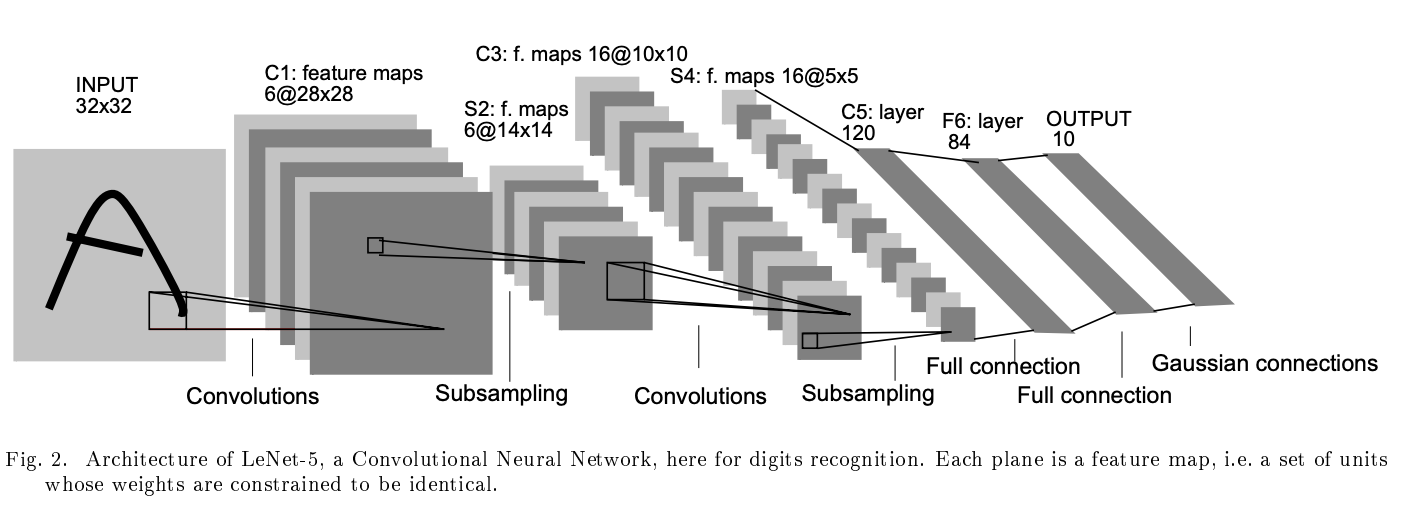

Let's implememt one of the classical convolutional network and apply it for CIFAR-10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implementation of LeNet5 has Tanh as nonlinearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [6]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
    
            
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
## TODO: define network, put it to the device and train mode


For a quick overview of models, torchsummary.summary is quite helpful  
comment: You can also import predefined architectures from `torchvision` and run `torchsummary.summary` on them to get a quick overview

In [22]:
## TODO: run torchsummary.summary on the LeNet5 and your MLP model. What do you see?

In [ ]:
## TODO: define loss function and optimizer


In [ ]:
## TODO: train with 20 epochs
num_epochs = 20


## Analysis 

In [ ]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

In [ ]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?

In [ ]:
## TODO: Plot the confusion matrix for LeNet5


## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in performance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
